In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 50)
np.random.seed(7)

## Step 1 — Simulate raw log data
A typical request log may include:

- `timestamp` (when the request happened)
- `endpoint` (route like `/api/login`)
- `method` (GET/POST)
- `status` (HTTP status code)
- `latency_ms` (response time)
- `bytes` (response size)
- `user_id` (anonymized)
- `region` (client region)
- `cache_hit` (whether cached)

We will intentionally add **messy values** (missing fields, wrong types, outliers) to make the processing realistic.





In [ ]:
#do step 1 here
import numpy as np
import pandas as pd

def simulate_logs(hours=24, house_count=10000, seed=None):
    if seed is not None:
        np.random.seed(seed)

    n = hours * 60
    time_stamps = np.arange(1, n + 1)

    # Public car chargers (kWh per minute aggregated across city chargers)
    mu = 3.7876811131611228
    sigma = 0.8899150743790847
    public_car_chargers = np.random.lognormal(mean=mu, sigma=sigma, size=n)

    # Residential (kWh per minute aggregated across all houses)
    residential_house = np.random.randint(
        int((house_count * 5) / (24 * 60)),
        int((house_count * 40) / (24 * 60)) + 1,
        size=n
    )

    # --- Added columns (kWh per minute) ---

    # 1) Small commercial load (shops/offices): higher during daytime
    day_shape = (np.sin((np.arange(n) / 60 - 6) * np.pi / 12) + 1) / 2  # 0..1 peak ~noon
    small_commercial = np.random.lognormal(mean=2.2, sigma=0.5, size=n) * (0.3 + 1.2 * day_shape)

    # 2) Streetlights: mostly at night
    hour = (np.arange(n) / 60) % 24
    is_night = (hour >= 18) | (hour <= 6)
    streetlights = np.where(
        is_night,
        np.random.normal(loc=35, scale=6, size=n),   # kWh/min aggregated
        np.random.normal(loc=4, scale=1.5, size=n)
    )
    streetlights = np.clip(streetlights, 0, None)

    # 3) Water treatment / pumping: fairly steady with occasional spikes
    water_treatment = np.random.normal(loc=55, scale=4, size=n)
    spikes = np.random.rand(n) < 0.01
    water_treatment[spikes] += np.random.uniform(80, 200, size=spikes.sum())
    water_treatment = np.clip(water_treatment, 0, None)

    # 4) HVAC load (city-wide): peaks afternoon; mild at night
    hvac = np.random.lognormal(mean=2.8, sigma=0.35, size=n) * (0.4 + 1.6 * day_shape)

    # 5) Solar generation (as negative load): only daytime
    solar = np.where(
        (hour >= 7) & (hour <= 17),
        np.random.normal(loc=120, scale=25, size=n) * day_shape,
        0
    )
    solar = np.clip(solar, 0, None)
    solar_generation = -solar  # negative kWh/min offsets demand

    df = pd.DataFrame({
        "TimeStamp": time_stamps,
        "public_car_chargers": public_car_chargers,
        "residential_house": residential_house,
        "small_commercial": small_commercial,
        "streetlights": streetlights,
        "water_treatment": water_treatment,
        "hvac_load": hvac,
        "solar_generation": solar_generation,
    })

    return df
df = simulate_logs()
print(df)

      TimeStamp  public_car_chargers  residential_house
0             1            87.166585                134
1             2             6.453555                253
2             3            42.100021                126
3             4            17.435131                224
4             5            52.961781                222
...         ...                  ...                ...
1435       1436            18.667452                160
1436       1437            41.362589                200
1437       1438            54.248581                244
1438       1439            12.378908                180
1439       1440            80.868654                 68

[1440 rows x 3 columns]


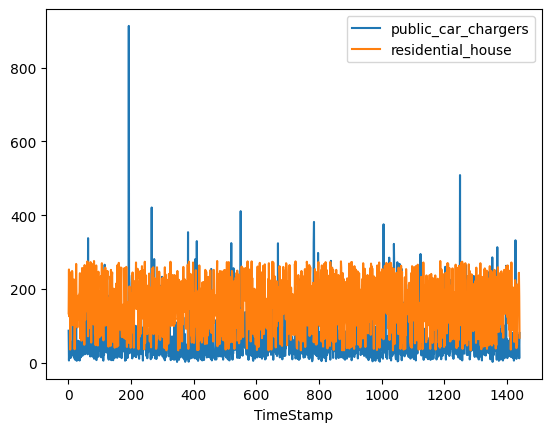

In [10]:
import matplotlib.pyplot as plt

x = df["TimeStamp"]

for col in df.columns:
    if col != "TimeStamp":
        plt.plot(x, df[col], label=col)

plt.xlabel("TimeStamp")
plt.legend()
plt.show()

## Step 2 — Basic DataFrame understanding
Key first steps:

1) `info()` (dtypes + missing values)
2) `describe()` for numeric columns
3) check for duplicates and missingness

raw.info()
raw.describe(include='all').T
# Missing values per column
raw.isna().sum().sort_values(ascending=False)


In [ ]:
#do step 2 here

## Step 3 — Cleaning and type fixes
Common issues we will fix:

- `timestamp` should be datetime
- `bytes` contains strings like `'12,345'`
- negative latency values
- missing endpoints

We'll produce a clean DataFrame called `df`.


In [ ]:
#do step 3 here

## Step 4 — Handling outliers (realistic)
Response time often has a long tail. We typically **cap** extreme values or remove them depending on context.

Here we will cap at the 99th percentile (winsorize) so plots are readable, but we keep the rows.

p99 = df["latency_ms"].quantile(0.99)
df["latency_ms_capped"] = df["latency_ms"].clip(upper=p99)

p99



In [ ]:
#do step 4 here

## Step 5 — Feature engineering
Feature engineering = creating useful columns for analysis.

We'll create:

- `minute` (timestamp floored to minute) for time aggregation
- `hour`
- `endpoint_group` (collapse `/api/items/123` into `/api/items/{id}`)
- `is_error`
- `latency_bucket` (fast/ok/slow)


In [ ]:
#do step 5 here

## Step 6 — Aggregations (the core of processing)
### A) Traffic over time
Requests per minute + error rate per minute.

In [ ]:
#do step 6 here

## Step 7 — A simple 'anomaly' idea (optional)
If time allows: flag minutes where traffic is unusually high.

We'll compute a rolling mean and find points above mean + 2*std.


In [ ]:
#do step 7 here

## Summary of what we did
- simulated messy, realistic CS log data
- loaded into a DataFrame
- inspected data types and missingness
- cleaned and fixed types
- capped outliers for readability
- engineered features for analysis
- aggregated (groupby) and visualized trends

This is the *standard data processing pipeline* you can reuse on many datasets.